In [48]:
import json

import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from scipy import stats
import matplotlib.pyplot as plt


# cred_file = 'credentials_local.json'
cred_file = 'credentials.json'
# use 'credentials.json' to connect to the remote database

# Load a dictionary of credentials
with open(cred_file) as fp:
    creds = json.load(fp)

db_url = 'postgresql+psycopg2://' + \
    '{user}:{password}@{host}:{port}/{database}' \
    .format(**creds)

engine = create_engine(db_url)

This analysis uses the results of questions 1 and 2 of part 3 of the project, so we repeat the code from there.

In [ ]:
def conditional_commit():
    """Commit if major version number is greater than 1"""
    if int(sqlalchemy.__version__.split('.')[0]) > 1:
        psql_conn.commit()

In [4]:
with engine.connect() as psql_conn:
    # 1.
    diagnoses = pd.read_sql_table('diagnosis', psql_conn)
    diagnoses.rename({'patient': 'ssno', 'reportdate': 'diagnosisdate'},
                     axis=1, inplace=True)

    patients = pd.read_sql_table('patients', psql_conn)
    patients.drop('name', axis=1, inplace=True)

    patientsymptoms = pd.merge(patients, diagnoses,
                               on='ssno', how='right')

    patientsymptoms = patientsymptoms[['ssno', 'gender', 'dateofbirth',
                                       'symptom', 'diagnosisdate']]

    patientsymptoms.to_sql('patientsymptoms', psql_conn,
                           if_exists='replace', index=True)

    conditional_commit()


In [5]:
with engine.connect() as psql_conn:
    # 2.
    vaccpats = pd.read_sql_table('vaccinepatients', psql_conn)
    vaccinations = pd.read_sql_table('vaccinations', psql_conn)
    batches = pd.read_sql_table('vaccinebatch', psql_conn)

    batches.drop(['numvaccines', 'manufacturer', 'dateproduced',
                  'expirationdate', 'location'],
                 axis=1, inplace=True)

    vaccpats = pd.merge(vaccpats, vaccinations,
                        on=('vaccinationdate', 'location'),
                        how='left')

    vaccpats = pd.merge(vaccpats, batches,
                        on='batchid',
                        how='left')

    vaccpats.sort_values(by='vaccinationdate', inplace=True)

    vaccpats.rename({'patientssno': 'ssno'}, inplace=True, axis=1)

    nulls = [None] * patients.shape[0]
    pvi = pd.concat([patients.ssno,
                    pd.DataFrame({'date1': nulls,
                                  'vaccinetype1': nulls,
                                  'date2': nulls,
                                  'vaccinetype2': nulls})],
                    axis=1)

    pvi.set_index('ssno', inplace=True)
    for _, row in vaccpats.iterrows():
        if pvi.isna().loc[row.ssno, 'date1']:
            pvi.loc[row.ssno, 'date1'] = row.vaccinationdate
            pvi.loc[row.ssno, 'vaccinetype1'] = row.vaccineid
        elif pvi.isna().loc[row.ssno, 'date2']:
            pvi.loc[row.ssno, 'date2'] = row.vaccinationdate
            pvi.loc[row.ssno, 'vaccinetype2'] = row.vaccineid
        else:
            raise Exception('Third vaccination found')

    pvi.reset_index(inplace=True)
    pvi.to_sql('patientvaccineinfo', psql_conn,
               if_exists='replace', index=True)

    conditional_commit()


We are interested in whether there is a difference in the tendency of vaccines to cause symptoms depending on which type of vaccine is given.  We look at data of information about what vaccines patients have received and what symptoms were reported.

In [49]:
with engine.connect() as psql_conn:
    pvi = pd.read_sql_table('patientvaccineinfo', psql_conn)
    diagnoses = pd.read_sql_table('patientsymptoms', psql_conn)

We take diagnoses only where they occur on or after the initial vaccination date

In [50]:
diag_and_vac_info = pd.merge(diagnoses, pvi, on='ssno', how='left')
diag_and_vac_info = diag_and_vac_info[
    pd.to_datetime(diag_and_vac_info.diagnosisdate)
    >= pd.to_datetime(diag_and_vac_info.date1)]

Examining the patient vaccine info where patients have received two doses:

In [51]:
pvi[pvi.vaccinetype2.notna()]

,index,ssno,date1,vaccinetype1,date2,vaccinetype2
0,0,841229-112N,2021-01-30,V01,2021-02-14,V03
11,11,890104-753F,2021-01-30,V01,2021-02-14,V03
15,15,840805-1135,2021-01-30,V01,2021-02-14,V03
40,40,751211-287B,2021-01-30,V01,2021-02-14,V03
44,44,060421-302M,2021-03-16,V01,2021-05-10,V02
52,52,880810-358W,2021-01-30,V03,2021-02-14,V03
60,60,090416-443L,2021-03-16,V01,2021-05-10,V02
66,66,871128-519R,2021-03-16,V01,2021-05-10,V02
68,68,010327-525G,2021-03-16,V01,2021-05-10,V02
74,74,090226-5673,2021-03-16,V01,2021-05-10,V02


We see that there are only 12 patients that have received two doses, and usually they are of different types.  So we only look at patients who received a first and only a first dose and compute the number of symptoms that were reported for each patient.

In [52]:

# take only rows where patient did not receive a second dose
pvi = pvi[pvi.date2.isna()]

# remove rows where patient did not receive a first dose
pvi = pvi.dropna(subset=['date1'])[['ssno', 'date1', 'vaccinetype1']]


In [53]:
# get counts of diagnoses for each patient
grps = diag_and_vac_info.groupby('ssno')
counts = grps.count().rename({'index_x': 'count_'}, axis=1) \
    .reset_index()[['ssno', 'count_']]

type_counts = pd.merge(pvi, counts, on='ssno', how='left')

type_counts['count_'] = type_counts.count_.fillna(0)


We take a look at the data.

In [54]:
type_counts

,ssno,date1,vaccinetype1,count_
0,780214-1893,2021-01-30,V01,1.0
1,950303-191X,2021-02-14,V03,2.0
2,730218-253D,2021-03-16,V01,3.0
3,971214-2818,2021-02-14,V03,1.0
4,060325-323X,2021-01-30,V03,4.0
...,...,...,...,...
70,850310-787I,2021-05-10,V01,3.0
71,090602-7898,2021-05-10,V02,0.0
72,041113-8113,2021-05-10,V02,1.0
73,090518-869W,2021-05-10,V02,1.0


In [55]:
type_counts.vaccinetype1.value_counts()

V03    30
V01    24
V02    21
Name: vaccinetype1, dtype: int64

We would like to use scipy.stats's f_oneway function to perform an ANOVA analysis.  This requires that variances are equal and that either data is normally distributed or there are a lot of data points.  Clearly there are not many data points, so we look to see if the data might be approximately normally distributed by looking at histograms.

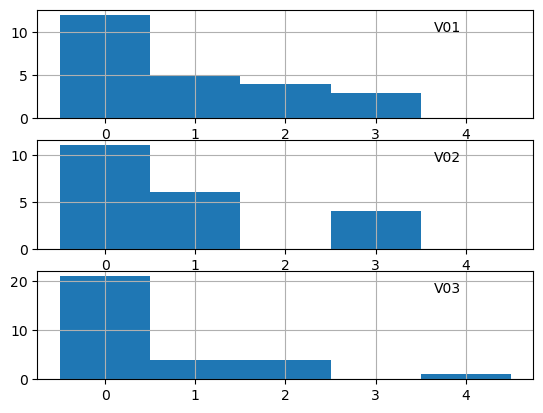

In [56]:
counts_v01 = type_counts.count_[type_counts.vaccinetype1 == 'V01']
counts_v02 = type_counts.count_[type_counts.vaccinetype1 == 'V02']
counts_v03 = type_counts.count_[type_counts.vaccinetype1 == 'V03']


def add_text_axis_coord(ax, x, y, s, **kwargs):
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    xd = x1 + (x2 - x1)*x
    yd = y1 + (y2 - y1)*y
    return ax.text(xd, yd, s, **kwargs)


fig, axes = plt.subplots(3, 1)
labels = ['V01', 'V02', 'V03']

bins = np.linspace(-0.5, 4.5, 6)

_ = counts_v01.hist(ax=axes[0], bins=bins)
_ = counts_v02.hist(ax=axes[1], bins=bins)
_ = counts_v03.hist(ax=axes[2], bins=bins)

for ax, lab in zip(axes, labels):
    _ = add_text_axis_coord(ax, 0.8, 0.8, lab)


It looks like there might be a difference in the effects between V03 and the other data. However, obviously these data are not normally distributed, so we must abandon our original approach.   Instead, we convert our data to binary, where 1 represents the case where the number of symptom reports is greater than zero, and 0 represents no symptoms being reported.  We then perform pairwise comparisons using the two-sample proportion test, where for any pair of samples, the null hypothesis is that probabilities of a 1 occurring are equal.  Since the probability for at least one type I error among the three combinations is increased, we must adjust the required p-value to be one third of the prescribed significance level, which we chose to be 0.05 as is typically done.  That is, we apply the Bonferroni correction and look for p-values less than 0.01667.

In [57]:
def two_sample_proportion_test(X, Y):
    """
    Returns the p-value from a two-sample proportion test.
    This is based on lecture slides from the course:
    MS-C1620 Statistical Inference at Aalto University in Spring 2023
    taught by Jukka Kohonen.
    :param X: One sample of binary data
    :param Y: Another sample of binary data
    :return: p-value
    """
    assert X.apply(lambda u: u in {0, 1}).all()
    assert Y.apply(lambda u: u in {0, 1}).all()
    n = len(X)
    m = len(Y)
    sx = X.sum()
    sy = Y.sum()

    theta_x = sx/n
    theta_y = sy/m

    theta = (sx + sy) / (n + m)

    Z = (theta_x - theta_y) \
        / np.sqrt(theta * (1 - theta) * (1 / n + 1 / m))

    warning_message = 'Results are not statistically accurate'
    if n * theta_x <= 5:
        print(f'Warning n * theta_hat_x <= 5.  {warning_message}')
    if n * (1 - theta_x) <= 5:
        print(f'Warning n * (1 - theta_hat_x) <= 5.  {warning_message}')
    if m * theta_y <= 5:
        print(f'Warning m * theta_hat_y <= 5.  {warning_message}')
    if m * (1 - theta_y) <= 5:
        print(f'Warning m * (1 - theta_hat_y) <= 5.  {warning_message}')

    p = 2 * stats.norm().cdf(-np.abs(Z))
    return p

p = two_sample_proportion_test(1 * (counts_v03 > 0),
                               1 * (counts_v02 > 0))

print(f'p-value = {p}')

p = two_sample_proportion_test(1 * (counts_v03 > 0),
                               1 * (counts_v01 > 0))

print(f'p-value = {p}')

p = two_sample_proportion_test(1 * (counts_v02 > 0),
                               1 * (counts_v01 > 0))

print(f'p-value = {p}')

p-value = 0.2002590712500678
p-value = 0.13412008326379768
p-value = 0.873351235048516


While it did look like there might be a difference of symptoms depending on vaccine type, there is not enough evidence to rule out that this might have occurred by chance.